<a href="https://colab.research.google.com/github/Zhang-Liao/lee-ml/blob/master/hw13_meta_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt


生成 $ a*\sin(x+b) $ 的資料點，其中 $a, b$ 的範圍分別預設為 $[0.1, 5], [0, 2\pi]$，每一個 $ a*\sin(x+b) $ 的函數有 10 個資料點當作訓練資料。測試時則可用較密集的資料點直接由畫圖來看 generalize 的好壞。



In [3]:
device = 'cpu'
def meta_task_data(seed = 0, a_range=[0.1, 5], b_range = [0, 2*np.pi], task_num = 100,
                   n_sample = 10, sample_range = [-5, 5], plot = False):
    np.random.seed(seed)
    a_s = np.random.uniform(low = a_range[0], high = a_range[1], size = task_num)
    b_s = np.random.uniform(low = b_range[0], high = b_range[1], size = task_num)
    total_x = []
    total_y = []
    label = []
    for t in range(task_num):
        x = np.random.uniform(low = sample_range[0], high = sample_range[1], size = n_sample)
        total_x.append(x)
        total_y.append( a_s[t]*np.sin(x+b_s[t]) )
        label.append('{:.3}*sin(x+{:.3})'.format(a_s[t], b_s[t]))
    if plot:
        plot_x = [np.linspace(-5, 5, 1000)]
        plot_y = []
        for t in range(task_num):
            plot_y.append( a_s[t]*np.sin(plot_x+b_s[t]) )
        return total_x, total_y, plot_x, plot_y, label
    else:
        return total_x, total_y, label

# **Homework 13 - Meta Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

以下我們將老師 MAML 投影片第 27 頁的 $\phi$ 稱作 meta weight，$\theta$ 則稱為 sub weight。

老師投影片： http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf

***

為了讓 sub weight 的 gradient 能夠傳到 meta weight (因為 sub weight 的初始化是從 meta weight 來的，所以想當然我們用 sub weight 算出來的 loss 對 meta weight 也應該是可以算 gradient 才對)，這邊我們需要重新定義一些 PyTorch 內的 layer 的運算。

實際上 *MetaLinear* 這個 class 做的事情跟 torch.nn.Linear 完全是一樣的，唯一的差別在於這邊的每一個 tensor 都沒有被變成 torch.nn.Parameter。這麼做的原因是因為等一下我們從 meta weight 那裏複製 (init weight 輸入 meta weight 後 weight 與 bias 使用 .clone) 的時候，tensor 的 clone 的操作是可以傳遞 gradient 的，以方便我們用 gradient 更新 meta weight。這個寫法的代價是我們就沒辦法使用 torch.optim 更新 sub weight 了，因為參數都只用 tensor 紀錄。也因此我們接下來需要自己寫 gradient update 的函數 (只用 SGD 的話是簡單的)。

In [4]:
class MetaLinear(nn.Module):
    def __init__(self, init_layer = None):
        super(MetaLinear, self).__init__()
        if type(init_layer) != type(None):
            self.weight = init_layer.weight.clone()
            self.bias = init_layer.bias.clone()
    def zero_grad(self):
        self.weight.grad  = torch.zeros_like(self.weight)
        self.bias.grad  = torch.zeros_like(self.bias)
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)





這裡的 forward 和一般的 model 是一樣的，唯一的差別在於我們需要多寫一下 \_\_init\_\_ 函數讓他比起一般的 PyTorch model 多一個可以從 meta weight 複製的功能 (這邊因為我把 model 的架構寫死了所以可能看起來會有點多餘，讀者可以自己把 net() 改成可以自己調整架構的樣子，然後思考一下如何生成一個跟 meta weight 一樣形狀的 sub weight)

update 函數就如同前一段提到的，我們需要自己先手動用 SGD 更新一次 sub weight，接著再使用下一步的 gradient (第二步) 來更新 meta weight。zero_grad 函數在此處沒有用到，因為實際上我們計算第二步的 gradient 時會需要第一步的 grad，這也是為什麼我們第一次 backward 的時候需要 create_graph=True (建立計算圖以計算二階的 gradient)

In [5]:
class net(nn.Module):
    def __init__(self, init_weight=None):
        super(net, self).__init__()
        if type(init_weight) != type(None):
            for name, module in init_weight.named_modules():
                if name != '':
                    setattr(self, name, MetaLinear(module))
        else:
            self.hidden1 = nn.Linear(1, 40)
            self.hidden2 = nn.Linear(40, 40)
            self.out = nn.Linear(40, 1)

    def zero_grad(self):
        layers = self.__dict__['_modules']
        for layer in layers.keys():
            layers[layer].zero_grad()
    def update(self, parent, lr = 1):
        layers = self.__dict__['_modules']
        parent_layers = parent.__dict__['_modules']
        for param in layers.keys():
            layers[param].weight = layers[param].weight - lr*parent_layers[param].weight.grad
            layers[param].bias = layers[param].bias - lr*parent_layers[param].bias.grad
        # gradient will flow back due to clone backward

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)




前面的 class 中我們已經都將複製 meta weight 到 sub weight，以及 sub weight 的更新， gradient 的傳遞都搞定了，meta weight 自己本身的參數就可以按照一般 PyTorch model 的模式，使用 torch.optim 來更新了。

gen_model 函數做的事情其實就是產生 N 個 sub weight，並且使用前面我們寫好的複製 meta weight 的功能。

注意到複製 weight 其實是整個 code 的關鍵，因為我們需要將 sub weight 計算的第二步 gradient 正確的傳回 meta weight。讀者從 meta weight 與 sub weight 更新參數作法的差別 (手動更新 / 用 torch.nn.Parameter 與 torch.optim) 可以再思考一下兩者的差別。



In [6]:
class Meta_learning_model():
    def __init__(self, init_weight = None):
        super(Meta_learning_model, self).__init__()
        self.model = net().to(device)
        if type(init_weight) != type(None):
            self.model.load_state_dict(init_weight)
        self.grad_buffer = 0
    def gen_models(self, num, check = True):
        models = [net(init_weight=self.model).to(device) for i in range(num)]
        return models
    def clear_buffer(self):
        print("Before grad", self.grad_buffer)
        self.grad_buffer = 0

接下來就是生成訓練 / 測試資料，建立 meta weightmeta weight 的模型以及用來比較的 model pretraining 的模型

In [7]:
bsz = 10
train_x, train_y, train_label = meta_task_data(task_num=50000*10)
train_x = torch.Tensor(train_x).unsqueeze(-1) # add one dim
train_y = torch.Tensor(train_y).unsqueeze(-1)
train_dataset = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=bsz, shuffle=False)

test_x, test_y, plot_x, plot_y, test_label = meta_task_data(task_num=1, n_sample = 10, plot=True)
test_x = torch.Tensor(test_x).unsqueeze(-1) # add one dim
test_y = torch.Tensor(test_y).unsqueeze(-1) # add one dim
plot_x = torch.Tensor(plot_x).unsqueeze(-1) # add one dim
test_dataset = data.TensorDataset(test_x, test_y)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False)


meta_model = Meta_learning_model()

meta_optimizer = torch.optim.Adam(meta_model.model.parameters(), lr = 1e-3)


pretrain = net()
pretrain.to(device)
pretrain.train()
pretrain_optim = torch.optim.Adam(pretrain.parameters(), lr = 1e-3)

/tmp/ipykernel_8430/3951922295.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343899977/work/torch/csrc/utils/tensor_new.cpp:245.)
  train_x = torch.Tensor(train_x).unsqueeze(-1) # add one dim


進行訓練，注意一開始我們要先生成一群 sub weight (code 裡面的 sub models)，然後將一個 batch 的不同的 sin 函數的 10 筆資料點拿來訓練 sub weight。注意這邊 sub weight 計算第一步 gradient 與第二步 gradient 時使用各五筆不重複的資料點 (因此使用 [:5] 與 [5:] 來取)。但在訓練 model pretraining 的對照組時則沒有這個問題 (所以 pretraining 的 model 是可以確實的走兩步 gradient 的)

每一個 sub weight 計算完 loss 後相加 (內層的 for 迴圈) 後就可以使用 optimizer 來更新 meta weight，再次提醒一下 sub weight 計算第一次 loss 的時候 backward 是需要 create_graph=True 的，這樣計算第二步 gradient 的時候才會真的計算到二階的項。讀者可以在這個地方思考一下如何將這段程式碼改成 MAML 的一階做法。

In [8]:
epoch = 1
for e in range(epoch):
    meta_model.model.train()
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        sub_models = meta_model.gen_models(bsz)

        meta_l = 0
        for model_num in range(len(sub_models)):


            sample = list(range(10))
            np.random.shuffle(sample)

            #pretraining
            pretrain_optim.zero_grad()
            y_tilde = pretrain(x[model_num][sample[:5],:])
            little_l = F.mse_loss(y_tilde, y[model_num][sample[:5],:])
            little_l.backward()
            pretrain_optim.step()
            pretrain_optim.zero_grad()
            y_tilde = pretrain(x[model_num][sample[5:],:])
            little_l = F.mse_loss(y_tilde, y[model_num][sample[5:],:])
            little_l.backward()
            pretrain_optim.step()

            # meta learning second order

            # y_tilde = sub_models[model_num](x[model_num][sample[:5],:])
            # little_l = F.mse_loss(y_tilde, y[model_num][sample[:5],:])
            #計算第一次 gradient 並保留計算圖以接著計算更高階的 gradient
            # little_l.backward(create_graph = True)
            # sub_models[model_num].update(lr = 1e-2, parent = meta_model.model)
            #先清空 optimizer 中計算的 gradient 值 (避免累加)
            # meta_optimizer.zero_grad()

            #計算第二次 (二階) 的 gradient，二階的原因來自第一次 update 時有計算過一次 gradient 了
            # y_tilde = sub_models[model_num](x[model_num][sample[5:],:])
            # meta_l =  meta_l + F.mse_loss(y_tilde, y[model_num][sample[5:],:])


            # meta learning first order

            y_tilde = sub_models[model_num](x[model_num][sample[:5],:])
            little_l = F.mse_loss(y_tilde, y[model_num][sample[:5],:])
            little_l.backward(create_graph = False)
            sub_models[model_num].update(lr = 1e-2, parent = meta_model.model)
            meta_optimizer.zero_grad()

            y_tilde = sub_models[model_num](x[model_num][sample[5:],:])
            meta_l =  meta_l + F.mse_loss(y_tilde, y[model_num][sample[5:],:])

        meta_l = meta_l / bsz
        meta_l.backward()
        meta_optimizer.step()
        meta_optimizer.zero_grad()

100%|██████████| 50000/50000 [1:21:08<00:00, 10.27it/s]


測試我們訓練好的 meta weight

In [9]:
test_model = copy.deepcopy(meta_model.model)
test_model.train()
test_optim = torch.optim.SGD(test_model.parameters(), lr = 1e-3)

先畫出待測試的 sin 函數，以及用圓點點出測試時給 meta weight 訓練的十筆資料點

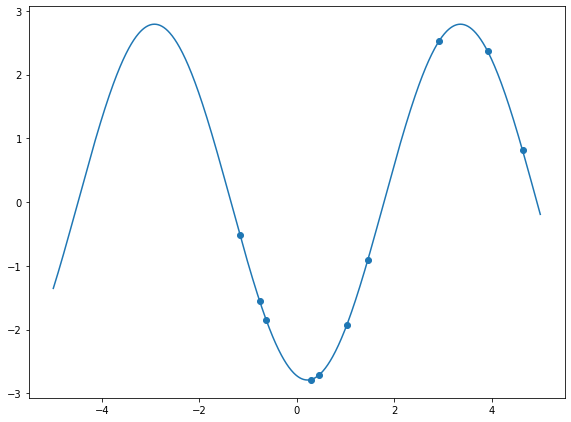

In [10]:
fig = plt.figure(figsize = [9.6,7.2])
ax = plt.subplot(111)
plot_x1 = plot_x.squeeze().numpy()
ax.scatter(test_x.numpy().squeeze(), test_y.numpy().squeeze())
ax.plot(plot_x1, plot_y[0].squeeze())

分別利用十筆資料點更新 meta weight 以及 pretrained model 一個 step

In [45]:
test_model.train()
pretrain.train()

for epoch in range(1):
    for x, y in test_loader:
        y_tilde = test_model(x[0])
        little_l = F.mse_loss(y_tilde, y[0])
        test_optim.zero_grad()
        little_l.backward()
        test_optim.step()
        print("(meta)))Loss: ", little_l.item())

for epoch in range(1):
    for x, y in test_loader:
        y_tilde = pretrain(x[0])
        little_l = F.mse_loss(y_tilde, y[0])
        pretrain_optim.zero_grad()
        little_l.backward()
        pretrain_optim.step()
        print("(pretrain)Loss: ", little_l.item())

(meta)))Loss:  0.5541966557502747
(pretrain)Loss:  3.824535369873047


將更新後的模型所代表的函數繪製出來，與真實的 sin 函數比較

In [46]:
test_model.eval()
pretrain.eval()

plot_y_tilde = test_model(plot_x[0]).squeeze().detach().numpy()
plot_x2 = plot_x.squeeze().numpy()
ax.plot(plot_x2, plot_y_tilde, label = 'tune(disjoint)')
ax.legend()
fig.show()

/tmp/ipykernel_8430/1918783042.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [47]:
plot_y_tilde = pretrain(plot_x[0]).squeeze().detach().numpy()
plot_x2 = plot_x.squeeze().numpy()
ax.plot(plot_x2, plot_y_tilde, label = 'pretrain')
ax.legend()

執行底下的 cell 以顯示圖形，並重複執行更新 meta weight 與 pretrained model 的 cell 來比較多更新幾步後是否真的能看出 meta learning 比 model pretraining 有效

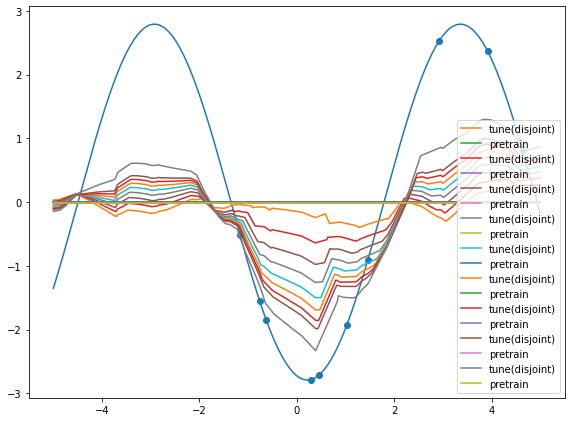

In [48]:
fig